In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import cross_val_score
from tabulate import tabulate
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

# Function to read the CSV file and handle errors
def load_data(file_path):
    """
    Load a CSV file into a DataFrame with error handling.

    Parameters:
    file_path (str): Path to the CSV file.

    Returns:
    pd.DataFrame or None: Loaded DataFrame if successful, None if an error occurs.
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded data from {file_path}\n")
        return df
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
        return None
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
        return None
    except pd.errors.ParserError:
        print("Error: The file could not be parsed.")
        return None


def remove_columns_with_all_missing(df):
    """
    Remove columns from the DataFrame that have 100% missing data.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: A DataFrame with columns having 100% missing data removed.
    """
    cleaned_df = df.dropna(axis=1, how='all')
    return cleaned_df

Successfully loaded data from listings.csv


Analyzing the dataset...

Number of rows: 426
Number of columns: 16
Number of columns with missing data: 3

Data types of each column:
+----+--------------------------------+-----------+
|    |             Column             | Data Type |
+----+--------------------------------+-----------+
| 0  |               id               |   int64   |
| 1  |              name              |  object   |
| 2  |            host_id             |   int64   |
| 3  |           host_name            |  object   |
| 4  |         neighbourhood          |  object   |
| 5  |            latitude            |  float64  |
| 6  |           longitude            |  float64  |
| 7  |           room_type            |  object   |
| 8  |             price              |  float64  |
| 9  |         minimum_nights         |   int64   |
| 10 |       number_of_reviews        |   int64   |
| 11 |          last_review           |  object   |
| 12 |       reviews_per_month        | 

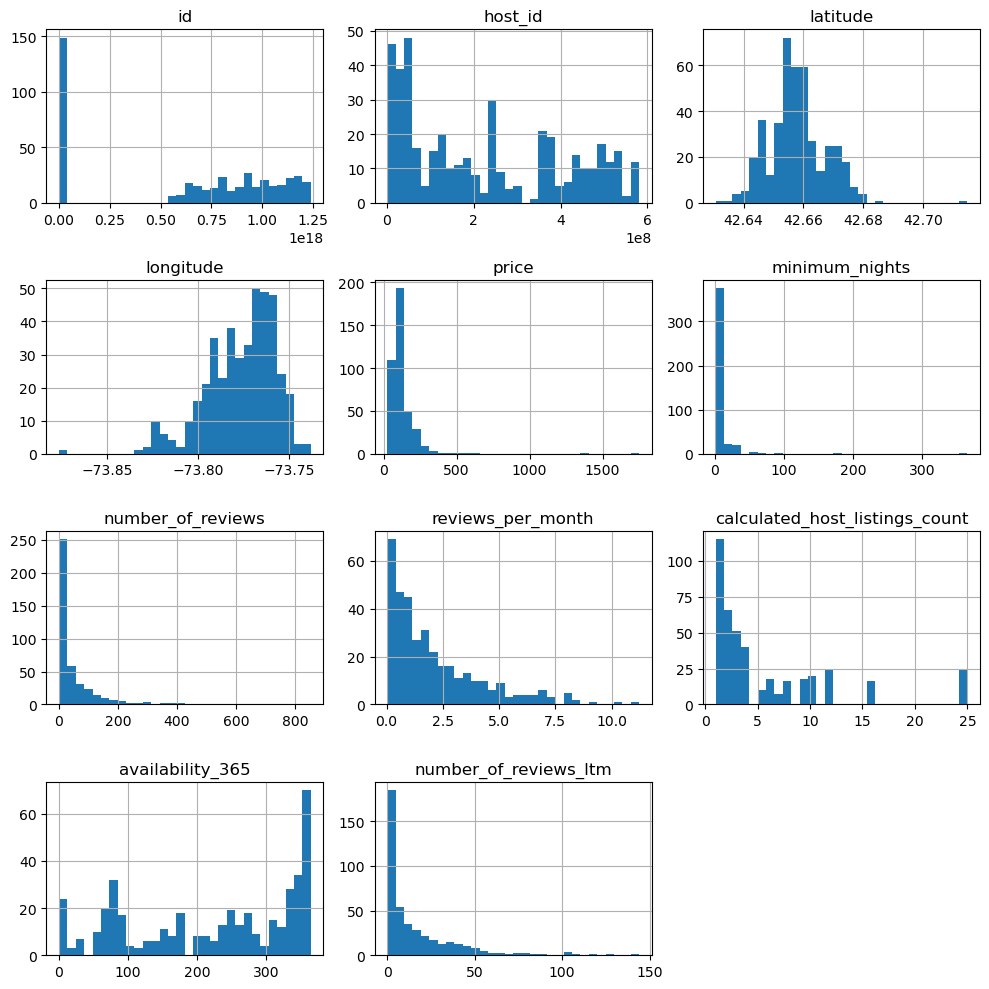

In [2]:
def display_data_info(df):
    """
    Display detailed information about the DataFrame, including:
    - Number of rows and columns.
    - Number of columns with missing data.
    - Data type of each column.
    - Summary statistics for numerical and categorical data.
    - Percentage of missing values per column.
    - Number of duplicate rows.
    - Number of unique values per column.
    - Correlation matrix for numerical columns.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    """
    print("\nAnalyzing the dataset...\n")
    
    num_rows, num_columns = df.shape
    print(f"Number of rows: {num_rows}")
    print(f"Number of columns: {num_columns}")
    
    missing_data_columns = df.isna().sum()
    num_missing_columns = (missing_data_columns > 0).sum()
    print(f"Number of columns with missing data: {num_missing_columns}")
    
    print("\nData types of each column:")
    print(tabulate(df.dtypes.reset_index(), headers=['Column', 'Data Type'], tablefmt='pretty'))
    
    print("\nSummary statistics for numerical data:")
    print(tabulate(df.describe(), headers='keys', tablefmt='pretty'))
    
    print("\nSummary statistics for categorical data:")
    print(tabulate(df.describe(include='object'), headers='keys', tablefmt='pretty'))
    
    missing_percentage = (df.isna().sum() / len(df)) * 100
    print("\nPercentage of missing values per column:")
    print(tabulate(missing_percentage.reset_index(), headers=['Column', 'Missing Percentage'], tablefmt='pretty'))
    
    duplicate_rows = df.duplicated().sum()
    print(f"\nNumber of duplicate rows: {duplicate_rows}")
    
    print("\nNumber of unique values per column:")
    unique_counts = df.nunique()
    print(tabulate(unique_counts.reset_index(), headers=['Column', 'Unique Values'], tablefmt='pretty'))
    
    print("\nCorrelation matrix for numerical columns:")
    numeric_df = df.select_dtypes(include=[np.number])
    print(tabulate(numeric_df.corr(), headers='keys', tablefmt='pretty'))
    
    '''
    # Optional: Value counts for categorical columns
    print("\nValue counts for categorical columns:")
    for col in df.select_dtypes(include=['object']).columns:
        print(f"\nValue counts for {col}:")
        print(tabulate(df[col].value_counts().reset_index(), headers=['Value', 'Count'], tablefmt='pretty'))
    '''
    
    print("\nData analysis completed.\n")


def plot_numerical_histograms(df):
    """
    Plot histograms for all numerical columns in the DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    """
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns].hist(figsize=(10, 10), bins=30)
    plt.tight_layout()
    plt.show()


# Main execution
file_path = 'listings.csv'
df = load_data(file_path)

if df is not None:
    # Remove columns with all missing data
    new_df = remove_columns_with_all_missing(df)

    # Convert 'last_review' to datetime and extract date only
    new_df.loc[:, 'last_review'] = pd.to_datetime(new_df['last_review'], errors='coerce').dt.date

    # Display data information and plot histograms
    display_data_info(new_df)
    plot_numerical_histograms(new_df)

In [9]:
# Function to display DataFrame in chunks of rows and columns
def display_dataframe_in_chunks(new_df):
    """
    Display the DataFrame in chunks of rows and columns, with user customization.

    Parameters:
    new_df (pd.DataFrame): The DataFrame to display.

    Behavior:
    - Allows users to specify the number of rows and columns to display interactively.
    - Displays the specified number of rows and columns at a time.
    - Prompts the user to continue viewing the next chunk of columns.
    """
    # Ask the user for the number of rows and columns to display
    try:
        rows = int(input("Enter the number of rows to display: ").strip())
        cols = int(input("Enter the number of columns to display: ").strip())
    except ValueError:
        print("Invalid input. Using default values of 3 rows and 5 columns.")
        rows, cols = 3, 5

    total_columns = new_df.shape[1]
    
    # Loop through the DataFrame in chunks of columns
    for start_col in range(0, total_columns, cols):
        end_col = min(start_col + cols, total_columns)
        
        # Display the current chunk of columns and rows
        print(tabulate(new_df.iloc[:rows, start_col:end_col], headers='keys', tablefmt='pretty'))
        
        # Check if there are more columns to display
        if end_col < total_columns:
            user_input = input("Do you want to see the next set of columns? (yes/no): ").strip().lower()
            if user_input != 'yes':
                print("Exiting...")
                break
        else:
            print("No more columns to display.")
            break

# Call the function to display the DataFrame
display_dataframe_in_chunks(new_df)


+----+----------+----------------------------------------------------+-----------+---------------------+-----------------+-----------+------------+-----------------+-------+----------------+-------------------+-------------+-------------------+--------------------------------+------------------+-----------------------+
|    |    id    |                        name                        |  host_id  |      host_name      |  neighbourhood  | latitude  | longitude  |    room_type    | price | minimum_nights | number_of_reviews | last_review | reviews_per_month | calculated_host_listings_count | availability_365 | number_of_reviews_ltm |
+----+----------+----------------------------------------------------+-----------+---------------------+-----------------+-----------+------------+-----------------+-------+----------------+-------------------+-------------+-------------------+--------------------------------+------------------+-----------------------+
| 0  | 2992450  |             Luxury 

In [5]:
def impute_missing_values(new_df):
    """
    Impute missing values in the specified columns of the DataFrame.
    
    Parameters:
    new_df (pd.DataFrame): The DataFrame containing the data.
    
    Returns:
    pd.DataFrame: The DataFrame with missing values imputed.
    """
    # Impute missing values for 'last_review' with a placeholder
    new_df.loc[:, 'last_review'] = new_df['last_review'].fillna('No reviews')  
    # Rationale: If no reviews exist, it makes sense to explicitly state "No reviews."
    
    # Impute missing values for 'reviews_per_month' with the median
    new_df.loc[:, 'reviews_per_month'] = new_df['reviews_per_month'].fillna(new_df['reviews_per_month'].median())  
    # Rationale: The median is robust to outliers and provides a central value for imputation.
    
    # Impute missing values for 'price' with the median
    new_df.loc[:, 'price'] = new_df['price'].fillna(new_df['price'].median())  
    # Rationale: Using the median for price ensures outlier influence is minimized.

    return new_df

# Impute missing values in the dataset
new_df = impute_missing_values(new_df)


/var/folders/pq/lw1rm6ks5px4p9d2g0zd97440000gn/T/ipykernel_951/676084381.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['has_last_review'] = new_df['last_review'].apply(lambda x: 1 if x != 'No reviews' else 0)


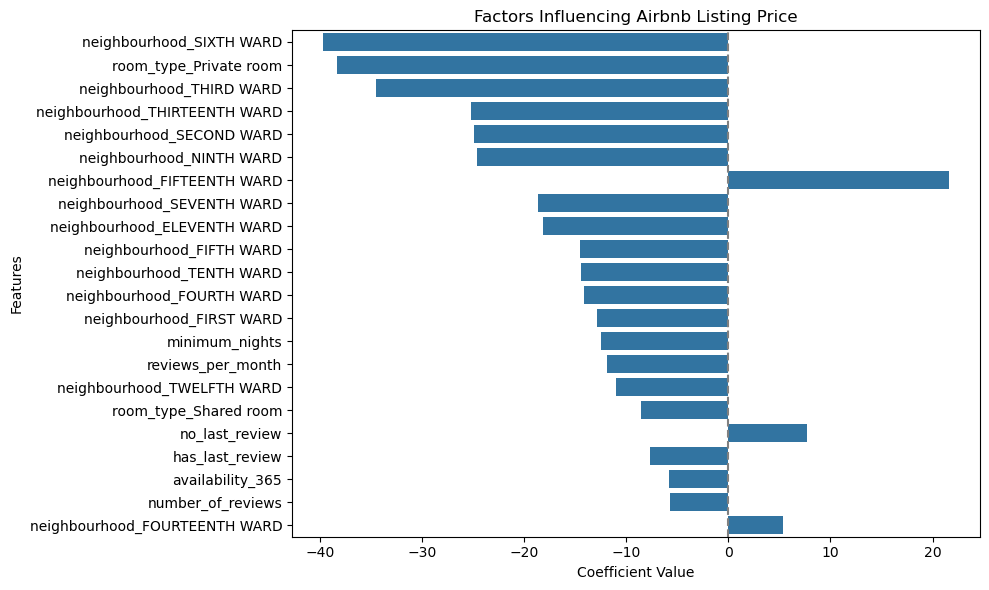


Model Evaluation:
R-squared: -0.21 - Indicates the proportion of variance explained by the model.
Mean Squared Error: 7221.34 - Measures the average squared difference between predicted and actual values.
Cross-Validated R-squared: -0.33 - Average R-squared across 5 folds.


In [6]:
def analyze_airbnb_price_factors(new_df):
    """
    Analyze the factors influencing Airbnb listing prices using linear regression.
    
    Parameters:
    new_df (pd.DataFrame): The preprocessed DataFrame containing Airbnb data.
    
    Returns:
    pd.DataFrame: A DataFrame containing the coefficients of the linear regression model for each feature.
    
    Process:
    1. Process 'last_review' to create binary features: 'has_last_review' and 'no_last_review'.
    2. Select relevant features and the target variable.
    3. Convert categorical variables to dummy variables for regression analysis.
    4. Split the dataset into training and testing sets.
    5. Train a linear regression model using a pipeline with standard scaling.
    6. Visualize the coefficients to interpret feature importance.
    7. Evaluate the model using R-squared, Mean Squared Error (MSE), and Cross-Validation.
    """
    
    # Create binary features for 'last_review'
    new_df['has_last_review'] = new_df['last_review'].apply(lambda x: 1 if x != 'No reviews' else 0)
    new_df['no_last_review'] = new_df['last_review'].apply(lambda x: 1 if x == 'No reviews' else 0)
    
    # Selecting relevant features for the analysis
    features = ['room_type', 'neighbourhood', 'minimum_nights', 
                'number_of_reviews', 'reviews_per_month', 'availability_365',
                'has_last_review', 'no_last_review']
    target = 'price'
    
    # Preprocessing: Convert categorical variables to dummy variables
    new_df = pd.get_dummies(new_df[features + [target]], drop_first=True)
    
    # Splitting the dataset into training and testing sets
    X = new_df.drop(target, axis=1)
    y = new_df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    
    # Fitting the linear regression model using a pipeline
    model = make_pipeline(StandardScaler(), LinearRegression())
    model.fit(X_train, y_train)
    
    # Extracting and sorting the coefficients by absolute value
    coefficients = pd.DataFrame(
        model.named_steps['linearregression'].coef_, 
        X.columns, 
        columns=['Coefficient']
    )
    coefficients = coefficients.reindex(coefficients['Coefficient'].abs().sort_values(ascending=False).index)
    
    # Visualizing the coefficients
    plt.figure(figsize=(10, 6))
    sns.barplot(x=coefficients['Coefficient'], y=coefficients.index)
    plt.title('Factors Influencing Airbnb Listing Price')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Features')
    plt.axvline(0, color='grey', linestyle='--')  # Add a vertical line at 0 for reference
    plt.tight_layout()
    plt.show()
    
    # Model evaluation
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    print("\nModel Evaluation:")
    print(f"R-squared: {r2:.2f} - Indicates the proportion of variance explained by the model.")
    print(f"Mean Squared Error: {mse:.2f} - Measures the average squared difference between predicted and actual values.")
    
    # Cross-validation
    cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(f"Cross-Validated R-squared: {cross_val_scores.mean():.2f} - Average R-squared across 5 folds.")
    
    return coefficients

# Analyze Airbnb price factors
coefficients = analyze_airbnb_price_factors(new_df)
